In [3]:
import os
if not os.path.exists('guided-filter-pytorch'):
    !git clone https://github.com/perrying/guided-filter-pytorch.git

import sys
sys.path.append('/kaggle/working/guided-filter-pytorch')

Cloning into 'guided-filter-pytorch'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 6), reused 20 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 3.80 MiB | 17.39 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from guided_filter import GuidedFilter2d
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

In [5]:
class CrackDataset(Dataset):
    """Custom Dataset for crack images and masks."""
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform: image = self.image_transform(image)
        if self.mask_transform: mask = self.mask_transform(mask)
        
        # Return mask as long tensor with values 0 or 1
        return image, (mask > 0.5).long()

In [6]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [7]:
BATCH_SIZE = 4
train_dataset = CrackDataset('/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/image', '/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/label', image_transform=image_transform, mask_transform=mask_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataset = CrackDataset('/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/image', '/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/label', image_transform=image_transform, mask_transform=mask_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [8]:
def init_net(net, gpu_ids=[]):
    """Helper to initialize network on GPU(s)."""
    if len(gpu_ids) > 0 and torch.cuda.is_available():
        net = net.cuda()
        net = nn.DataParallel(net, gpu_ids)
    return net

In [9]:
def calculate_class_weights(dataloader):
    """Calculate weights for positive and negative classes for Weighted BCE."""
    total_pixels, total_pos = 0, 0
    print("Calculating class weights for Weighted BCE...")
    for _, labels in tqdm(dataloader):
        total_pixels += labels.numel()
        total_pos += labels.sum().item()
    weight_pos = total_pixels / (2 * total_pos)
    weight_neg = total_pixels / (2 * (total_pixels - total_pos))
    print(f"Weight for Positive (crack): {weight_pos:.4f}, Weight for Negative (non-crack): {weight_neg:.4f}")
    return weight_pos, weight_neg

In [10]:
class DeepCrackLossBCE(nn.Module):
    """DeepCrack loss with standard BCE."""
    def __init__(self):
        super(DeepCrackLossBCE, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
    def forward(self, outputs, targets):
        targets_float = targets.float()
        total_loss = sum(self.bce_loss(output, targets_float) for output in outputs)
        return total_loss

In [11]:
class DeepCrackLossWeightedBCE(nn.Module):
    """DeepCrack loss with weighted BCE for class imbalance."""
    def __init__(self, weight_pos=1.0, weight_neg=1.0):
        super(DeepCrackLossWeightedBCE, self).__init__()
        self.weight_pos = weight_pos
        self.weight_neg = weight_neg
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, outputs, targets):
        targets_float = targets.float()
        weights = torch.where(targets > 0, self.weight_pos, self.weight_neg).to(targets.device)
        total_loss = sum((self.bce_loss(output, targets_float) * weights).mean() for output in outputs)
        return total_loss

In [12]:
class FocalLoss(nn.Module):
    """Standard Focal Loss implementation."""
    def __init__(self, alpha=0.75, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha, self.gamma = alpha, gamma
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * bce_loss
        return focal_loss.mean()

In [13]:
class DeepCrackLossFocal(nn.Module):
    """DeepCrack loss using Focal Loss."""
    def __init__(self):
        super(DeepCrackLossFocal, self).__init__()
        self.focal_loss = FocalLoss()
    def forward(self, outputs, targets):
        total_loss = sum(self.focal_loss(output, targets) for output in outputs)
        return total_loss

In [14]:
class DeepCrackNet_EfficientNet(nn.Module):
    """DeepCrack with an EfficientNet-B0 backbone."""
    def __init__(self, num_classes=1, pretrained=True):
        super(DeepCrackNet_EfficientNet, self).__init__()

        # 1. Load pretrained EfficientNet-B0 backbone
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = efficientnet_b0(weights=weights).features

        # 2. Define feature extraction nodes from backbone's stages
        return_nodes = {
            '1': 's1',  # 112x112, 16 channels
            '2': 's2',  # 56x56,   24 channels
            '3': 's3',  # 28x28,   40 channels
            '5': 's4',  # 14x14,   112 channels
            '7': 's5',  # 7x7,     320 channels
        }
        self.feature_extractor = create_feature_extractor(backbone, return_nodes=return_nodes)
        
        # 3. Define side-output convolution layers (1x1 conv)
        self.side_conv1 = nn.Conv2d(16, num_classes, 1)
        self.side_conv2 = nn.Conv2d(24, num_classes, 1)
        self.side_conv3 = nn.Conv2d(40, num_classes, 1)
        self.side_conv4 = nn.Conv2d(112, num_classes, 1)
        self.side_conv5 = nn.Conv2d(320, num_classes, 1)
        
        # 4. Define fuse layer and guided filter
        # The number of input channels for fuse_conv is now correct (5 * num_classes)
        self.fuse_conv = nn.Conv2d(num_classes * 5, num_classes, 1)
        self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

    def forward(self, x):
        # The input x is 224x224.
        
        # Extract features from the backbone
        features = self.feature_extractor(x)
        f1, f2, f3, f4, f5 = features['s1'], features['s2'], features['s3'], features['s4'], features['s5']
        
        # Generate side-outputs
        s1 = self.side_conv1(f1) # Size: [B, C, 112, 112]
        s2 = self.side_conv2(f2) # Size: [B, C, 56, 56]
        s3 = self.side_conv3(f3) # Size: [B, C, 28, 28]
        s4 = self.side_conv4(f4) # Size: [B, C, 14, 14]
        s5 = self.side_conv5(f5) # Size: [B, C, 7, 7]
        
        # ======================================================================
        # FIX: Upsample all side outputs to the size of the largest one (s1)
        # ======================================================================
        s2_up = F.interpolate(s2, size=s1.shape[2:], mode='bilinear', align_corners=False)
        s3_up = F.interpolate(s3, size=s1.shape[2:], mode='bilinear', align_corners=False)
        s4_up = F.interpolate(s4, size=s1.shape[2:], mode='bilinear', align_corners=False)
        s5_up = F.interpolate(s5, size=s1.shape[2:], mode='bilinear', align_corners=False)

        side_outputs = [s1, s2_up, s3_up, s4_up, s5_up]

        # Now, all tensors in side_outputs have the same spatial size (112x112)
        # So torch.cat will work correctly.
        fused = self.fuse_conv(torch.cat(side_outputs, dim=1))
        
        # The guided filter expects guidance and input to be the same size.
        # Here we use the upsampled fused map as both guidance and input.
        # If you intend to use the original image, it needs to be downsampled first.
        # Let's assume guidance is self-guidance for simplicity.
        guided_fused = self.guided_filter(fused, fused)
        
        # Upsample all outputs to the original image size (224x224) for loss calculation
        final_outputs = []
        for s in side_outputs:
            final_outputs.append(F.interpolate(s, size=x.shape[2:], mode='bilinear', align_corners=False))
        final_outputs.append(F.interpolate(guided_fused, size=x.shape[2:], mode='bilinear', align_corners=False))

        if self.training:
            return final_outputs # Return a list of tensors for deep supervision loss
        
        # For inference, return only the final fused and guided output, with sigmoid
        return torch.sigmoid(final_outputs[-1])

In [ ]:
class DeepCrackNet_EfficientNet(nn.Module):
    """DeepCrack with an EfficientNet-B0 backbone."""
    def __init__(self, num_classes=1, pretrained=True):
        super(DeepCrackNet_EfficientNet, self).__init__()

        # 1. Load pretrained EfficientNet-B0 backbone
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = efficientnet_b0(weights=weights).features

        # 2. Define feature extraction nodes from backbone's stages
        return_nodes = {
            '1': 's1',  # 112x112, 16 channels
            '2': 's2',  # 56x56,   24 channels
            '3': 's3',  # 28x28,   40 channels
            '5': 's4',  # 14x14,   112 channels
            '7': 's5',  # 7x7,     320 channels
        }
        self.feature_extractor = create_feature_extractor(backbone, return_nodes=return_nodes)
        
        # 3. Define side-output convolution layers (1x1 conv)
        self.side_conv1 = nn.Conv2d(16, num_classes, 1)
        self.side_conv2 = nn.Conv2d(24, num_classes, 1)
        self.side_conv3 = nn.Conv2d(40, num_classes, 1)
        self.side_conv4 = nn.Conv2d(112, num_classes, 1)
        self.side_conv5 = nn.Conv2d(320, num_classes, 1)
        
        # 4. Define fuse layer and guided filter
        # The number of input channels for fuse_conv is now correct (5 * num_classes)
        self.fuse_conv = nn.Conv2d(num_classes * 5, num_classes, 1)
        self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

    def forward(self, x):
        # The input x is 224x224.
        
        # Extract features from the backbone
        features = self.feature_extractor(x)
        f1, f2, f3, f4, f5 = features['s1'], features['s2'], features['s3'], features['s4'], features['s5']
        
        # Generate side-outputs
        s1 = self.side_conv1(f1) # Size: [B, C, 112, 112]
        s2 = self.side_conv2(f2) # Size: [B, C, 56, 56]
        s3 = self.side_conv3(f3) # Size: [B, C, 28, 28]
        s4 = self.side_conv4(f4) # Size: [B, C, 14, 14]
        s5 = self.side_conv5(f5) # Size: [B, C, 7, 7]
        
        # ======================================================================
        # FIX: Upsample all side outputs to the size of the largest one (s1)
        # ======================================================================
        s2_up = F.interpolate(s2, size=s1.shape[2:], mode='bilinear', align_corners=False)
        s3_up = F.interpolate(s3, size=s1.shape[2:], mode='bilinear', align_corners=False)
        s4_up = F.interpolate(s4, size=s1.shape[2:], mode='bilinear', align_corners=False)
        s5_up = F.interpolate(s5, size=s1.shape[2:], mode='bilinear', align_corners=False)

        side_outputs = [s1, s2_up, s3_up, s4_up, s5_up]

        # Now, all tensors in side_outputs have the same spatial size (112x112)
        # So torch.cat will work correctly.
        fused = self.fuse_conv(torch.cat(side_outputs, dim=1))
        
        # The guided filter expects guidance and input to be the same size.
        # Here we use the upsampled fused map as both guidance and input.
        # If you intend to use the original image, it needs to be downsampled first.
        # Let's assume guidance is self-guidance for simplicity.
        guided_fused = self.guided_filter(fused, fused)
        
        # Upsample all outputs to the original image size (224x224) for loss calculation
        final_outputs = []
        for s in side_outputs:
            final_outputs.append(F.interpolate(s, size=x.shape[2:], mode='bilinear', align_corners=False))
        final_outputs.append(F.interpolate(guided_fused, size=x.shape[2:], mode='bilinear', align_corners=False))

        if self.training:
            return final_outputs # Return a list of tensors for deep supervision loss
        
        # For inference, return only the final fused and guided output, with sigmoid
        return torch.sigmoid(final_outputs[-1])

In [15]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_save_name):
    """Training and validation loop."""
    model.to(device)
    history = {'train_loss': [], 'val_iou': []}
    best_iou = 0.0
    
    for epoch in range(num_epochs):
        model.train() # Switch to training mode
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad() # Zero the gradients
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward() # Backward pass
            optimizer.step() # Optimization step
            running_loss += loss.item()
            pbar.set_postfix({'Loss': loss.item()})
        
        history['train_loss'].append(running_loss / len(train_loader))

        # Validation
        model.eval() # Switch to evaluation mode
        total_iou = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="[Val]"):
                outputs = model(images.to(device))
                pred = (outputs > 0.5).float()
                
                # Calculate Intersection over Union (IoU)
                intersection = (pred * labels.to(device)).sum()
                union = pred.sum() + labels.to(device).sum() - intersection
                total_iou += (intersection + 1e-6) / (union + 1e-6)
        
        avg_iou = total_iou / len(val_loader)
        history['val_iou'].append(avg_iou.item())
        print(f"Epoch {epoch+1} | Train Loss: {history['train_loss'][-1]:.4f} | Val IoU: {avg_iou:.4f}")
        
        # Save the best model based on validation IoU
        if avg_iou > best_iou:
            best_iou = avg_iou
            torch.save(model.state_dict(), model_save_name)
            print(f"  -> New best model saved with IoU: {best_iou:.4f}")
            
    # Load the best performing model for visualization
    model.load_state_dict(torch.load(model_save_name))
    return model, history

In [16]:
def visualize(model, loader, device, title):
    """Visualize model predictions on a batch of data."""
    # Inverse normalization for visualization
    inv_norm = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(loader))
        outputs = model(images.to(device))
        pred = (outputs > 0.5).float()

        plt.figure(figsize=(15, 5))
        plt.suptitle(title, fontsize=16)
        # Show one example from the batch
        i = 0
        plt.subplot(1, 3, 1)
        plt.imshow(inv_norm(images[i]).permute(1, 2, 0).clamp(0, 1)); plt.title('Input'); plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(labels[i].squeeze(), cmap='gray'); plt.title('Ground Truth'); plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(pred[i].cpu().squeeze(), cmap='gray'); plt.title('Prediction'); plt.axis('off')
        plt.show()

Using device: cuda
Calculating class weights for Weighted BCE...


100%|██████████| 375/375 [00:21<00:00, 17.44it/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Weight for Positive (crack): 17.3183, Weight for Negative (non-crack): 0.5149

STARTING EXPERIMENTS FOR: EfficientNet-B0

--- Running: EfficientNet-B0 with Weighted BCE Loss ---


100%|██████████| 20.5M/20.5M [00:00<00:00, 125MB/s] 
[Val]: 100%|██████████| 100/100 [00:05<00:00, 16.93it/s]


Epoch 1 | Train Loss: 2.8357 | Val IoU: 0.0568
  -> New best model saved with IoU: 0.0568


[Val]: 100%|██████████| 100/100 [00:02<00:00, 41.21it/s]


Epoch 2 | Train Loss: 1.8445 | Val IoU: 0.1326
  -> New best model saved with IoU: 0.1326


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


Epoch 3 | Train Loss: 1.5101 | Val IoU: 0.2246
  -> New best model saved with IoU: 0.2246


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.98it/s]


Epoch 4 | Train Loss: 1.3393 | Val IoU: 0.2430
  -> New best model saved with IoU: 0.2430


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.43it/s]


Epoch 5 | Train Loss: 1.2335 | Val IoU: 0.2562
  -> New best model saved with IoU: 0.2562


[Val]: 100%|██████████| 100/100 [00:02<00:00, 38.95it/s]


Epoch 6 | Train Loss: 1.1600 | Val IoU: 0.2719
  -> New best model saved with IoU: 0.2719


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.28it/s]


Epoch 7 | Train Loss: 1.1146 | Val IoU: 0.2860
  -> New best model saved with IoU: 0.2860


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.64it/s]


Epoch 8 | Train Loss: 1.0773 | Val IoU: 0.2889
  -> New best model saved with IoU: 0.2889


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.20it/s]


Epoch 9 | Train Loss: 1.0424 | Val IoU: 0.2956
  -> New best model saved with IoU: 0.2956


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.51it/s]


Epoch 10 | Train Loss: 1.0157 | Val IoU: 0.3098
  -> New best model saved with IoU: 0.3098


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.08it/s]


Epoch 11 | Train Loss: 0.9884 | Val IoU: 0.2970


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.22it/s]


Epoch 12 | Train Loss: 0.9677 | Val IoU: 0.3259
  -> New best model saved with IoU: 0.3259


[Val]: 100%|██████████| 100/100 [00:02<00:00, 37.36it/s]


Epoch 13 | Train Loss: 0.9501 | Val IoU: 0.3169


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.79it/s]


Epoch 14 | Train Loss: 0.9310 | Val IoU: 0.3211


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.27it/s]


Epoch 15 | Train Loss: 0.9197 | Val IoU: 0.3249


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.11it/s]


Epoch 16 | Train Loss: 0.9158 | Val IoU: 0.3087


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.72it/s]


Epoch 17 | Train Loss: 0.9018 | Val IoU: 0.3067


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.07it/s]


Epoch 18 | Train Loss: 0.8869 | Val IoU: 0.3147


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.12it/s]


Epoch 19 | Train Loss: 0.8738 | Val IoU: 0.3235


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.93it/s]


Epoch 20 | Train Loss: 0.8671 | Val IoU: 0.3381
  -> New best model saved with IoU: 0.3381


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.29it/s]


Epoch 21 | Train Loss: 0.8564 | Val IoU: 0.3285


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.19it/s]


Epoch 22 | Train Loss: 0.8528 | Val IoU: 0.3275


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.77it/s]


Epoch 23 | Train Loss: 0.8477 | Val IoU: 0.3247


[Val]: 100%|██████████| 100/100 [00:02<00:00, 37.76it/s]


Epoch 24 | Train Loss: 0.8421 | Val IoU: 0.3345


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.72it/s]


Epoch 25 | Train Loss: 0.8346 | Val IoU: 0.3455
  -> New best model saved with IoU: 0.3455


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.44it/s]


Epoch 26 | Train Loss: 0.8325 | Val IoU: 0.3266


[Val]: 100%|██████████| 100/100 [00:02<00:00, 38.99it/s]


Epoch 27 | Train Loss: 0.8230 | Val IoU: 0.3363


[Val]: 100%|██████████| 100/100 [00:02<00:00, 38.96it/s]


Epoch 28 | Train Loss: 0.8219 | Val IoU: 0.3419


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.63it/s]


Epoch 29 | Train Loss: 0.8124 | Val IoU: 0.3396


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.49it/s]


Epoch 30 | Train Loss: 0.8138 | Val IoU: 0.3429


[Val]: 100%|██████████| 100/100 [00:02<00:00, 38.81it/s]


Epoch 31 | Train Loss: 0.8099 | Val IoU: 0.3422


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.44it/s]


Epoch 32 | Train Loss: 0.8070 | Val IoU: 0.3443


[Val]: 100%|██████████| 100/100 [00:02<00:00, 41.06it/s]


Epoch 33 | Train Loss: 0.8027 | Val IoU: 0.3169


[Val]: 100%|██████████| 100/100 [00:02<00:00, 38.88it/s]


Epoch 34 | Train Loss: 0.7980 | Val IoU: 0.3507
  -> New best model saved with IoU: 0.3507


[Val]: 100%|██████████| 100/100 [00:02<00:00, 38.41it/s]


Epoch 35 | Train Loss: 0.7941 | Val IoU: 0.3455


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.42it/s]


Epoch 36 | Train Loss: 0.7899 | Val IoU: 0.3400


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.93it/s]


Epoch 37 | Train Loss: 0.7896 | Val IoU: 0.3445


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.53it/s]


Epoch 38 | Train Loss: 0.7885 | Val IoU: 0.3413


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.45it/s]


Epoch 39 | Train Loss: 0.7833 | Val IoU: 0.3335


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.90it/s]


Epoch 40 | Train Loss: 0.7820 | Val IoU: 0.3392


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.87it/s]


Epoch 41 | Train Loss: 0.7755 | Val IoU: 0.3449


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.93it/s]


Epoch 42 | Train Loss: 0.7749 | Val IoU: 0.3679
  -> New best model saved with IoU: 0.3679


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.86it/s]


Epoch 43 | Train Loss: 0.7754 | Val IoU: 0.3495


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.47it/s]


Epoch 44 | Train Loss: 0.7720 | Val IoU: 0.3558


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.61it/s]


Epoch 45 | Train Loss: 0.7655 | Val IoU: 0.3514


[Val]: 100%|██████████| 100/100 [00:02<00:00, 37.30it/s]


Epoch 46 | Train Loss: 0.7675 | Val IoU: 0.3514


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.90it/s]


Epoch 47 | Train Loss: 0.7676 | Val IoU: 0.3506


[Val]: 100%|██████████| 100/100 [00:02<00:00, 39.83it/s]


Epoch 48 | Train Loss: 0.7663 | Val IoU: 0.3522


[Val]: 100%|██████████| 100/100 [00:02<00:00, 40.95it/s]


Epoch 49 | Train Loss: 0.7715 | Val IoU: 0.3539


[Val]: 100%|██████████| 100/100 [00:02<00:00, 41.04it/s]


Epoch 50 | Train Loss: 0.7624 | Val IoU: 0.3549


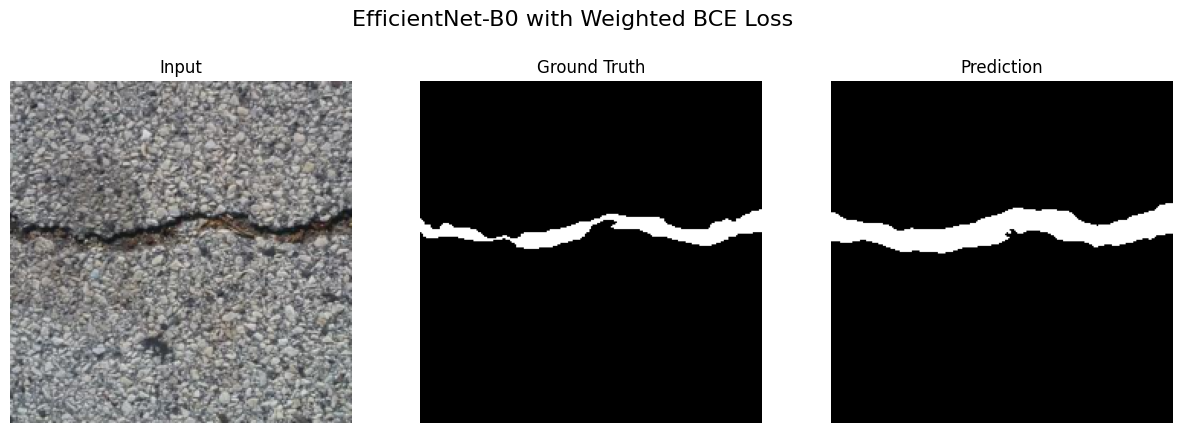


All experiments finished.


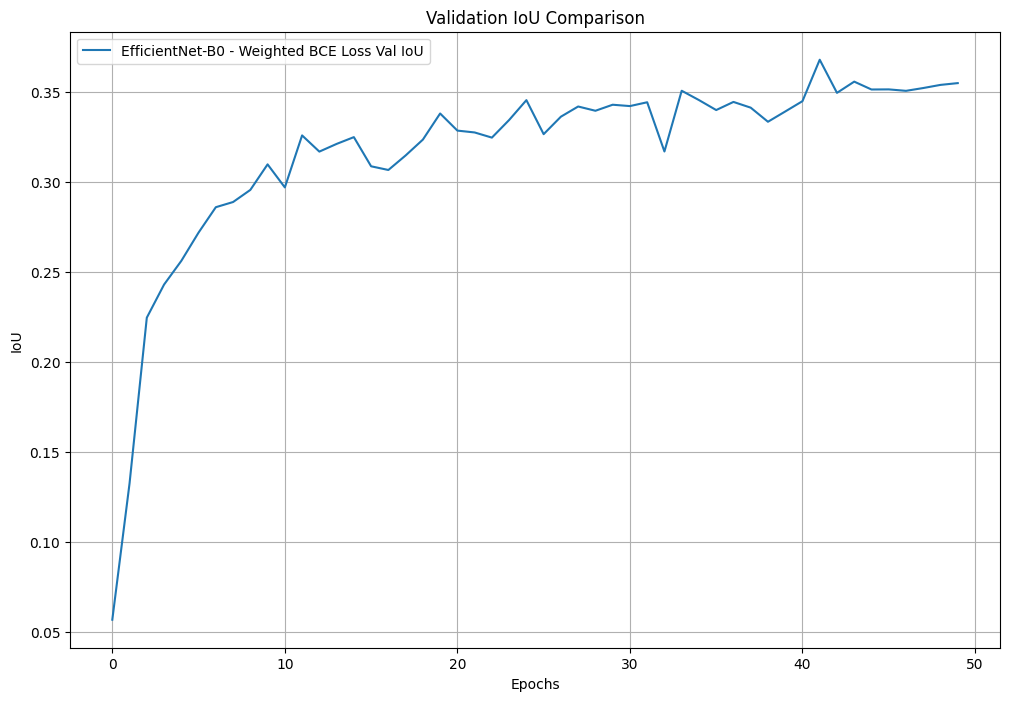

In [17]:
if __name__ == '__main__':
    # Set device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Hyperparameters
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-4

    # Calculate class weights for Weighted BCE loss
    w_pos, w_neg = calculate_class_weights(train_loader)
    
    # Define loss functions to test
    loss_functions = {
        # 'BCE Loss': DeepCrackLossBCE(),
        'Weighted BCE Loss': DeepCrackLossWeightedBCE(weight_pos=10, weight_neg=0.5),
        # 'Focal Loss': DeepCrackLossFocal()
    }
    
    # Define models to test
    models_to_train = {
        'EfficientNet-B0': DeepCrackNet_EfficientNet
    }

    all_histories = {}

    for model_name, model_class in models_to_train.items():
        print(f"\n{'='*60}\nSTARTING EXPERIMENTS FOR: {model_name}\n{'='*60}")
        all_histories[model_name] = {}
        
        for loss_name, loss_fn in loss_functions.items():
            experiment_name = f"{model_name} with {loss_name}"
            print(f"\n--- Running: {experiment_name} ---")
            
            # Initialize model and optimizer
            model = model_class()
            model = init_net(model, gpu_ids=[0] if torch.cuda.is_available() else [])
            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
            
            # Train the model
            model_save_path = f"{model_name.replace(' ', '_')}_{loss_name.replace(' ', '_')}_best.pth"
            model, history = train(model, train_loader, val_loader, loss_fn.to(device), optimizer, NUM_EPOCHS, device, model_save_path)
            
            all_histories[model_name][loss_name] = history
            
            # Visualize results
            visualize(model, val_loader, device, title=experiment_name)

    print("\nAll experiments finished.")

    # Optional: Plot comparison of validation IoU
    plt.figure(figsize=(12, 8))
    for model_name, histories in all_histories.items():
        for loss_name, history in histories.items():
            plt.plot(history['val_iou'], label=f"{model_name} - {loss_name} Val IoU")
    plt.title("Validation IoU Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    plt.legend()
    plt.grid(True)
    plt.show()